# Тема проекта: Телеком. Прогноз оттока клиентов.

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Постановка задачи

Используя предоставленную информацию и данные таблиц, необходимо обучить модель прогнозированию оттока клиентов из компании.  
Необходимо решить задачу классификации относящуюся к типу обучение с учителем.

Целевой признак: столбец `'EndDate'` равен `'No'`.

Основная метрика: AUC-ROC.  
Дополнительная метрика: Accuracy.

Критерии оценки:

- AUC-ROC < 0.75 — 0 sp
- 0.75 ≤ AUC-ROC < 0.81 — 4 sp
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
- 0.85 ≤ AUC-ROC < 0.87 — 5 sp
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
- AUC-ROC ≥ 0.88 — 6 sp

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Импорт необходимых библиотек и загрузка данных


In [1]:
# библиотеки работы с данными
import pandas as pd 
import numpy as np 

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

# обработка исключений для предупреждений pandas (без предупреждения, без исключения)
pd.options.mode.chained_assignment = None

# предобработка данных
from sklearn.model_selection import train_test_split # разделение на выборки
from sklearn.preprocessing import LabelEncoder, StandardScaler # кодирование и масштабирование признаков

# pandas merge multiple dataframes
from functools import reduce

# графики
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

# разделение на выборки
from sklearn.model_selection import train_test_split  
from sklearn.utils import shuffle

# модели
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # подбор гиперпараметров модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.dummy import DummyClassifier # базисная модель

# метрики
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score 
from sklearn.metrics import precision_score,recall_score, confusion_matrix

In [2]:
contract = pd.read_csv("/datasets/final_provider/contract.csv")
internet = pd.read_csv("/datasets/final_provider/internet.csv")
personal = pd.read_csv("/datasets/final_provider/personal.csv")
phone = pd.read_csv("/datasets/final_provider/phone.csv")

Таблицы успешно загружены.  

## Исследовательский анализ данных

Посмотрим на первые 5 строк каждой таблицы, на общую информацию о ней, на количество пропусков и дубликатов.

### Информация о договорах

In [3]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
contract.shape

(7043, 8)

В таблице contract содержится 7043 объектов исследования (строк) и 8 признаков объектов (столбцов)

Получим список всех признаков:

In [5]:
contract.columns.tolist()

['customerID',
 'BeginDate',
 'EndDate',
 'Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges']

**Описание признаков:**

* `customerID` - код клиента
* `BeginDate` - дата заключения договора с клиентом
* `EndDate` - дата ухода клиента (No - если остался)
* `Type` - тип установленного тарифа
* `PaperlessBilling` - данные о том, запрашивает ли клиент электронный чек по факту оплаты услуг
* `PaymentMethod` - способ оплаты
* `MonthlyCharges` - средняя месячная сумма затрат клиента на услуги связи
* `TotalCharges` - общая сумма затрат клиента на услуги связи

Проверим уникальность клиентов по их ID с учетом пропусков в данных, если они есть:

In [6]:
contract.customerID.nunique(dropna = False)

7043

Все клиенты уникальны

Посмотрим на типы данных в столбцах:

In [7]:
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

На первый взгляд можно заметить, что не все типы данных в contract корректны. Посмотрим подробнее:

In [8]:
contract.describe(include=['object'])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,4423-JWZJN,2014-02-01,No,Month-to-month,Yes,Electronic check,20.2
freq,1,366,5174,3875,4171,2365,11


Количество уникальных наблюдений по столбцам:

In [9]:
contract.nunique()

customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

Необходимо изменить типы данных в следующих столбцах:
* `BeginDate` - на datetime
* `TotalCharges` - на float
* `EndDate` - с учетом содержимого, тип данных корректен, но ПРЕДПОЛАГАЮ, что необходимо будет сгенерировать новый столбец `ClientLeft` на его основе, в котором будут следующие отметки:
    * `0` - если клиент действующий 
    * и `1` - если клиент разорвал договор 

Заменим типы данных сразу, чтобы далее было удобно посмотреть на описание статистик по числовым признакам  
Сначала в `BeginDate` - заменим тип на datetime

In [10]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Затем в `TotalCharges` - на float:  

при попытке замены типа данных в столбце `TotalCharges` мы получили ошибку невозможности конвертации строки в число,   
поэтому теперь проверим содержимое столбца в таких строках:

In [11]:
contract[pd.to_numeric(contract['TotalCharges'], errors='coerce').isnull()].TotalCharges.value_counts()

     11
Name: TotalCharges, dtype: int64

In [12]:
contract[pd.to_numeric(contract['TotalCharges'], errors='coerce').isnull()].TotalCharges == ' '

488     True
753     True
936     True
1082    True
1340    True
3331    True
3826    True
4380    True
5218    True
6670    True
6754    True
Name: TotalCharges, dtype: bool

В 11 строках обнаружена пустота, не обозначенная как пропущенное значение, т.к. содержит пробелы.  
Теперь произведем замену типа данных на вещественный с доп настройкой для замены вышеупомянутых строк на пропуски: 

In [13]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

Посмотрим на количество дубликатов и пропусков в contract:

In [14]:
contract.duplicated().sum()

0

Дубликатов не найдено.

In [15]:
contract.isna().sum().sum()

11

В датафрейме определено 11 пропусков (мы сами их создали на предыдущем шаге)  

Посмотрим на эти строки:

In [16]:
contract[contract.isnull().any(axis=1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


In [17]:
contract[contract.BeginDate == '2020-02-01'].BeginDate.count()

11

Можно отметить, что дата заключения договора в `BeginDate` одинакова у всех 11 вышеперечисленных клиентов: 2020-02-01.  

Т.к. крайняя дата записи информации в датафреймы определена как 1 февраля 2020 г, и всего записей с этой датой в датафрейме тоже 11, мы можем сделать вывод что общая потраченная сумма в `TotalCharges` из-за этого некорректно записалась в таблицу (изначально в виде пробелов).  

Можно было бы заменить такие пропуски на стоимость тарифа в соответствии с заполненными значениями в столбце `Type` (тип установленного тарифа), но в нашем распоряжении нет таких данных. 

Поэтому просто удалим эти 11 строк, т.к. это очень малая потеря в разрезе общего количества строк  
Сделаем это после мерджа таблиц на этапе предобработки данных.

Теперь можно посмотреть на статистики по датафрейму:

In [18]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


Видим, что 50% клиентов ежемесячно тратят на услуги связи более 70.3 ден.ед., а в среднем 64,8.  
У половины клиентов общее количество затрат на улуги связи - более 1397.5 ден.ед., а в среднем оно равно 2283.3, т.к. максимум общих затрат более чем в 2 раза больше медианы и равен 8684.8. Можно предположить, что такие затраты имеют довольно старые клиенты компании, т.к. тарифа всего 3 и хоть мы и не знаем их стоимости, сразу можно увидеть что среди них не выделено премиальных.

Посмотрим на графики распределения оставшихся и ушедших клиентов

In [19]:
# Клиенты которые не ушли
noleft = contract[contract.EndDate == "No"]

# Клиенты которые ушли 
left = contract[contract.EndDate != "No"]

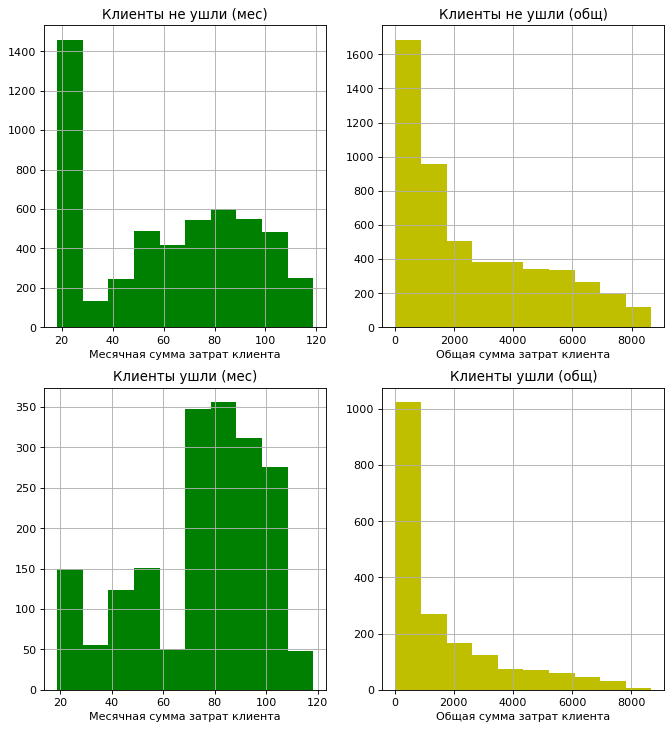

In [20]:
plt.figure(num=None, figsize=(10, 11), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 2, 1)
plt.hist(x = noleft['MonthlyCharges'], color = 'g')
plt.xlabel('Месячная сумма затрат клиента')
plt.title('Клиенты не ушли (мес)')
plt.grid()


plt.subplot(2, 2, 2)
plt.hist(x = noleft['TotalCharges'], color = 'y')
plt.xlabel('Общая сумма затрат клиента')
plt.title('Клиенты не ушли (общ)')
plt.grid()

plt.subplot(2, 2, 3)
plt.hist(x = left['MonthlyCharges'], color = 'g')
plt.xlabel('Месячная сумма затрат клиента')
plt.title('Клиенты ушли (мес)')
plt.grid()


plt.subplot(2, 2, 4)
plt.hist(x = left['TotalCharges'], color = 'y')
plt.xlabel('Общая сумма затрат клиента')
plt.title('Клиенты ушли (общ)')
plt.grid()

plt.show()

По графикам можно предположить, что чаще уходят клиенты с затратами в месяц более 60 ден. ед.,  
но с общими затратами менее 2 000 ден.ед., что свидетельствует о том что клиент не задерживается надолго

### Персональные данные клиента

In [21]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [22]:
personal.shape

(7043, 5)

В таблице 7043 строки и 5 столбцов

Получим список всех признаков:

In [23]:
personal.columns.tolist()

['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']

**Описание признаков:**

* `customerID` - код клиента
* `gender` - пол клиента
* `SeniorCitizen` - относится ли клиент к пенсионерам
* `Partner` - замужем или женат ли клиент
* `Dependents` - наличие у клиента иждивенцев 

Проверим уникальность клиентов по их ID с учетом пропусков в данных, если они есть,  
а также посмотрим на количество уникальных значений по всем столбцам:

In [24]:
personal.nunique(dropna = False)

customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64

Клиенты уникальны  
Во всех остальных столбцах определено всего по 2 уникальных значения, следовательно они относятся к категориальным

Посмотрим на типы данных в столбцах:

In [25]:
personal.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

Все типы данных корректны

Посмотрим на количество дубликатов и пропусков в personal:

In [26]:
personal.duplicated().sum()

0

In [27]:
personal.isna().sum().sum()

0

Дубликатов и пропусков не найдено.

Посмотрим на описательную статистику по клиентам в таблице personal:

In [28]:
personal.describe(include=['object'])

,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,4423-JWZJN,Male,No,No
freq,1,3555,3641,4933


Основное количество клиентов - люди мужского пола, не в отношениях, без детей / иждивенцев

Посмотрим также сходится ли количество клиентов из таблицы `personal` и `договоров` из таблицы contract:

In [29]:
contract.customerID.nunique() == personal.customerID.nunique()

True

In [30]:
personal.customerID.nunique()

7043

Количество контрактов равно количеству клиентов (7043).  
Здесь можно сделать предположение о том, что если значения в столбцах `customerID` обеих таблиц совпадают, то у каждого клиента из таблицы personal имеется 1 контракт с оператором связи «Ниединогоразрыва.ком» из таблицы contract.

### Информация об интернет-услугах

In [31]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [32]:
internet.shape

(5517, 8)

В таблице определено 5517 строк и 8 столбцов

Получим список всех признаков:

In [33]:
internet.columns.tolist()

['customerID',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

**Описание признаков:**
* `customerID` - код клиента
* `InternetService` - тип подключения
* `OnlineSecurity` - интернет-безопасность: блокировка небезопасных сайтов
* `OnlineBackup` - облачное хранилище файлов для резервного копирования данных
* `DeviceProtection` - интернет-безопасность: антивирус
* `TechSupport` - выделенная линия технической поддержки
* `StreamingTV` - стриминговое телевидение
* `StreamingMovies` - каталог фильмов

Проверим уникальность клиентов по их ID с учетом пропусков в данных, если они есть,  
а также посмотрим на количество уникальных значений по всем столбцам:

In [34]:
internet.nunique(dropna = False)

customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

Клиенты уникальны  
Во всех остальных столбцах определено всего по 2 уникальных значения, следовательно они относятся к категориальным

Посмотрим на типы данных в столбцах:

In [35]:
internet.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

Все типы данных корректны

Посмотрим на количество дубликатов и пропусков в internet:

In [36]:
internet.duplicated().sum()

0

In [37]:
internet.isna().sum().sum()

0

Дубликатов и пропусков не найдено.

Посмотрим на описательную статистику по интернет-услугам в таблице internet:

In [38]:
internet.describe(include=['object'])

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3071-VBYPO,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Самое популярное подключение к сети - оптоволоконный кабель  
без антивируса, блокировки небезопасных сайтов, выделенной линии тех поддержки, облака, каталога фильмов и стримингового тв.

### Информация об услугах телефонии

In [39]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [40]:
phone.shape

(6361, 2)

В таблице определено 6361 строк и 2 столбца  

Проверим уникальность клиентов по их ID с учетом пропусков в данных, если они есть,  
а также посмотрим на количество уникальных значений по другому столбцу:

In [41]:
phone.nunique(dropna = False)

customerID       6361
MultipleLines       2
dtype: int64

Клиенты уникальны  
В столбце `MultipleLines` определено всего 2 уникальных значения

Посмотрим на типы данных в столбцах:

In [42]:
phone.dtypes

customerID       object
MultipleLines    object
dtype: object

Все типы данных корректны

Получим список признаков:

In [43]:
phone.columns.tolist()

['customerID', 'MultipleLines']

**Описание признаков:**
* `customerID` - код клиента
* `MultipleLines` - наличие подключения к телефонной линии

Посмотрим на количество дубликатов и пропусков в internet:

In [44]:
phone.duplicated().sum()

0

In [45]:
phone.isna().sum().sum()

0

Дубликатов и пропусков не найдено.

Посмотрим на описательную статистику:

In [46]:
phone.describe(include=['object'])

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,4423-JWZJN,No
freq,1,3390


Основное количество клиентов не пользуется подключением к услугам телефонии

### Вывод

На этапе анализа данных, мы просмотрели все таблицы и выяснили несколько важных моментов:
* все коды клиентов уникальны в каждой таблице - это очень удачная основа для дальнейшего объединения таблиц в одну единую
* количество уникальных клиентов соответсвует количеству уникальных контрактов, что является основой для предположения что у каждого клиента из таблицы personal есть контракт в таблице contract, а следовательно и остальная информация о нем
* пропуски в малом количестве есть только на позициях общих затрат у клиентов, оформивших контракт в последний день выгрузки данных из системы, что является логичным их объяснением
* у дат неверно определен тип данных
* таблицы с информацией об интернет-услугах и услугах телефонии содержат значительно меньше строк, чем contract и personal: это означает, что не каждый клиент пользуется услугами на полную катушку :) можно предположить, что одни пользуются только телефоном, другие только интернетом, и очень немногие и тем, и другим сразу
* самое популярное подключение к сети - оптоволоконный кабель
* также по графикам мы определили, что клиенты с затратами в месяц более 60 ден. ед. в основном не задерживаются надолго

## Предобработка данных

### Объединение датафреймов

Объединим все 4 датафрейма по общему столбцу с кодом клиента `customerID` и удостоверимся что данные не потерялись 

In [67]:
dfs = [contract, personal, internet, phone]
df = reduce(lambda  left, right: pd.merge(left, right, on=['customerID'], how='outer'), dfs)

df.shape

(7043, 20)

In [68]:
df.customerID.nunique()

7043

In [69]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU,9305-CDSKC,1452-KIOVK,6713-OKOMC,7892-POOKP,6388-TABGU,...,9767-FFLEM,0639-TSIQW,8456-QDAVC,7750-EYXWZ,2569-WGERO,6840-RESVB,2234-XADUH,4801-JZAZL,8361-LTMKD,3186-AJIEK
BeginDate,2020-01-01 00:00:00,2017-04-01 00:00:00,2019-10-01 00:00:00,2016-05-01 00:00:00,2019-09-01 00:00:00,2019-03-01 00:00:00,2018-04-01 00:00:00,2019-04-01 00:00:00,2017-07-01 00:00:00,2014-12-01 00:00:00,...,2016-12-01 00:00:00,2014-03-01 00:00:00,2018-07-01 00:00:00,2019-02-01 00:00:00,2014-02-01 00:00:00,2018-02-01 00:00:00,2014-02-01 00:00:00,2019-03-01 00:00:00,2019-07-01 00:00:00,2014-08-01 00:00:00
EndDate,No,No,2019-12-01 00:00:00,No,2019-11-01 00:00:00,2019-11-01 00:00:00,No,No,2019-11-01 00:00:00,No,...,No,2019-10-01 00:00:00,No,No,No,No,No,No,2019-11-01 00:00:00,No
Type,Month-to-month,One year,Month-to-month,One year,Month-to-month,Month-to-month,Month-to-month,Month-to-month,Month-to-month,One year,...,Month-to-month,Month-to-month,Month-to-month,One year,Two year,One year,One year,Month-to-month,Month-to-month,Two year
PaperlessBilling,Yes,No,Yes,No,Yes,Yes,Yes,No,Yes,No,...,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes
PaymentMethod,Electronic check,Mailed check,Mailed check,Bank transfer (automatic),Electronic check,Electronic check,Credit card (automatic),Mailed check,Electronic check,Bank transfer (automatic),...,Credit card (automatic),Credit card (automatic),Bank transfer (automatic),Electronic check,Bank transfer (automatic),Mailed check,Credit card (automatic),Electronic check,Mailed check,Bank transfer (automatic)
MonthlyCharges,29.85,56.95,53.85,42.3,70.7,99.65,89.1,29.75,104.8,56.15,...,69.5,102.95,78.7,60.65,21.15,84.8,103.2,29.6,74.4,105.65
TotalCharges,29.85,1889.5,108.15,1840.75,151.65,820.5,1949.4,301.9,3046.05,3487.95,...,2625.25,6886.25,1495.1,743.3,1419.4,1990.5,7362.9,346.45,306.6,6844.5
gender,Female,Male,Male,Male,Female,Female,Male,Female,Female,Male,...,Male,Female,Male,Female,Female,Male,Female,Female,Male,Male
SeniorCitizen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Отлично. Данные на месте.  

### Обработка пропусков

Посмотрим на наличие пропусков в новом датафрейме:

In [70]:
df.isna().sum().sum()

11375

Достаточно большое количество данных утеряно при объединении таблиц.  
Посмотрим по столбцам:

In [71]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Пропуски в столбце общих расходов на услуги связи в `TotalCharges ` мы разбирали на этапе анализа данных и пришли к заключению что т.к. мы не знаем стоимости оплаченных ими тарифов (там у всех договор на 1 или 2 года), то заполнить мы их не сможем, и их не жалко удалить, т.к. это будет малая потеря (всего 11 строк).

In [72]:
df.dropna(subset =['TotalCharges'], inplace = True)
df.shape

(7032, 20)

По пропускам в услугах и в наличии подключения к услугам телефонии можно сделать предположение, что сформированы они там где услуга или Multiple Line отсутствует, поэтому можно смело заменить их на значение `No`

In [73]:
df = df.fillna('No')

df.isna().sum().sum()

0

### Создание дополнительных фичей

Добавим фичу `TotalTime` с рассчитанным общим периодом обслуживания клиента.  

Чтобы не потерять целевой признак: где столбец 'EndDate' равен 'No', создадим перед этим фичу `ClientLeft` с отметками 1 (и 0  там где дата заполнена)

In [74]:
df['ClientLeft'] = df['EndDate'].copy()
df.ClientLeft[df['ClientLeft'] != 'No'] = 1
df.ClientLeft[df['ClientLeft'] == 'No'] = 0

df['ClientLeft'] = pd.to_numeric(df['ClientLeft'])

df.ClientLeft.value_counts()

0    5163
1    1869
Name: ClientLeft, dtype: int64

Для того чтобы провести рассчет `TotalTime` с начала и до конечной даты формирования датафреймов данных ('2020-02-01'),  
все показатели `No` в столбце `EndDate` заменим на последнюю дату учета, а затем произведем рассчет вычитанием,  
сразу определив тип данных новой фичи `TotalTime` как вещественный

In [75]:
df['EndDate'] = df['EndDate'].replace('No','2020-02-01')
df['EndDate'] = pd.to_datetime(df['EndDate'])

In [76]:
df['TotalTime'] = ( df['EndDate'] - df['BeginDate'] ) / pd.to_timedelta(1, unit='D')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

In [77]:
df['ClientLeft'] = pd.to_numeric(df['ClientLeft'])

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   7032 non-null   object        
 13  OnlineSecurity    7032 non-null   object        
 14  OnlineBackup      7032 n

In [79]:
df.shape

(7032, 22)

Удостоверившись, что 2 новых столбца добавлены и типы данных корректны,  
мы можем без сожаления удалить ненужные столбцы с датами `EndDate` и `BeginDate`, чтобы приступить к кодированию данных

In [80]:
df.drop(['EndDate', 'BeginDate'], axis='columns', inplace=True)
df.shape

(7032, 20)

Также можно предположить, что столбец `PaperlessBilling`, с запросом клиента чека по оплате услуг, совершенно никак не должен быть связан с фактом ухода клиента, поэтому его тоже можно смело удалить:

In [81]:
df.drop('PaperlessBilling', axis='columns', inplace=True)
df.shape

(7032, 19)

### Вывод

На данном этапе были удалены пропуски в общих затратах, т.к. их немного и это незнакительная потеря;  
пропуски в услугах были заменены на `No`, а также были сформированы новые фичи: 
* `TotalTime` (общее время с начала заключения договора до его расторжения, либо до крайней даты загрузки данных) и 
* `ClientLeft` (где `1` - клиент разорвал контракт) - целевой признак

## Подготовка данных к моделированию

### Деление датасета на таргет и фичи

Перед делением определим код клиента как индекс

In [82]:
df.customerID.nunique()

7032

In [83]:
df.set_index('customerID', inplace=True)

Разделим датасет на таргет и фичи:

In [84]:
features = df.drop(['ClientLeft'], axis=1)
target = df['ClientLeft']

print('Размер исходного датафрейма:', df.shape,
      '\nРазмер features:', features.shape,
      '\nРазмер target:', target.shape)

Размер исходного датафрейма: (7032, 18) 
Размер features: (7032, 17) 
Размер target: (7032,)


### Построение графика кореляции количественных признаков

In [87]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaymentMethod     7032 non-null   object 
 2   MonthlyCharges    7032 non-null   float64
 3   TotalCharges      7032 non-null   float64
 4   gender            7032 non-null   object 
 5   SeniorCitizen     7032 non-null   int64  
 6   Partner           7032 non-null   object 
 7   Dependents        7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  MultipleLines     7032 non-null   object 
 16  TotalTime         7032 non-null 

In [88]:
num_cols = ['MonthlyCharges', 'TotalCharges', 'TotalTime']

In [95]:
features[num_cols].corr()

,MonthlyCharges,TotalCharges,TotalTime
MonthlyCharges,1.000000,0.651065,0.246715
TotalCharges,0.651065,1.000000,0.825811
TotalTime,0.246715,0.825811,1.000000


In [96]:
correlation = features[num_cols].corr()
matrix_cols = num_cols
corr_array  = np.array(correlation)

trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Коэффициент корреляции Пирсона",
                                     titleside = "right")
                  )

layout = go.Layout(dict(title = "Матрица корреляции количественных признаков",
                        autosize = False,
                        height  = 500,
                        width   = 500,
                        yaxis   = dict(tickfont = dict(size = 11)),
                        xaxis   = dict(tickfont = dict(size = 11))
                       )
                  )

fig = go.Figure(data=trace,layout=layout)
py.iplot(fig)

По графику видно что у нас присутствует проблема мультиколлинеарности:  
количественные признаки `TotalCharges` и `TotalTime` имеют сильную корреляцию друг с другом (0,82) 

Проблема заключается в том, что при дальнейшем обучении моделей, это наличие сильно коррелирующих количественных признаков может привести к переобучению  

Чтобы решить проблему, необходимо удалить один из признаков:  
удалим `TotalCharges` - он менее ценен т.к. у него также присутствует достаточно высокая корреляция с признаком `MonthlyCharges`  

In [97]:
features.drop('TotalCharges', axis='columns', inplace=True)

features.shape

(7032, 16)

### Кодирование категориальных признаков

Сначала определим список категориальных признаков:

In [98]:
cat_cols = features.nunique()[features.nunique() < 6].keys().tolist()
cat_cols

['Type',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

Кодирование категориальных признаков произведем при помощи создания dummy-переменных (т.е. используем метод прямого кодирования `OHE`):

In [99]:
features_ohe = pd.get_dummies(data = features, columns=cat_cols, drop_first=True)

features_ohe.head()

,MonthlyCharges,TotalTime,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,29.85,31.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,56.95,1036.0,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,53.85,61.0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,42.30,1371.0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0
9237-HQITU,70.70,61.0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Деление на выборки

Определим тренировочную, валидационную и тестовую выборки:

In [128]:
features_train, features_testvalid, target_train, target_testvalid = train_test_split(
features_ohe, target, test_size=0.4, shuffle=False, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
features_testvalid, target_testvalid, test_size=0.5, shuffle=False, random_state=42)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер valid:', features_valid.shape, target_valid.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (4219, 20) (4219,) 
Размер valid: (1406, 20) (1406,) 
Размер test: (1407, 20) (1407,)


### Масштабирование численных признаков

Произведем масштабирование при помощи `StandardScaler()`

In [129]:
num_cols = [i for i in features.columns if features[i].dtype == 'float64']
num_cols

['MonthlyCharges', 'TotalTime']

Для того, чтобы избежать переобучения, обучим стандартизатор на тренировочном датасете, а стандартизировать будем всё:

In [130]:
scaler = StandardScaler()

scaler.fit(features_train[num_cols])

features_train[num_cols] = scaler.transform(features_train[num_cols])
features_valid[num_cols] = scaler.transform(features_valid[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

features_train.head()

,MonthlyCharges,TotalTime,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,-1.161087,-1.267989,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
5575-GNVDE,-0.260862,0.073477,1,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0
3668-QPYBK,-0.363840,-1.227945,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0
7795-CFOCW,-0.747515,0.520632,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0
9237-HQITU,0.195895,-1.227945,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Данные подготовлены и корректно поделены на выборки.  
Можно приступать к этапу моделирования

## Моделирование

### Логистическая регрессия (LogisticRegression)
#### При дисбалансе классов

In [136]:
model_lr =  LogisticRegression(random_state=42, solver='liblinear', class_weight = 'balanced')

model_lr.fit(features_train, target_train)
prediction_lr = model_lr.predict_proba(features_valid)
prediction_lr_one_valid = prediction_lr[:, 1]

auc_roc_lr = roc_auc_score(target_valid, prediction_lr_one_valid).round(5)

print('AUC-ROC:', auc_roc_lr)

AUC-ROC: 0.82755


#### Upsampling   

Т.к. у нас присутствует дисбаланс классов, используем функцию, реализующую задачу увеличения выборки меньшего класса

In [137]:
repeat = round(len(df.query('ClientLeft==0')) / len(df.query('ClientLeft==1')))
repeat

3

In [138]:
def upsample(features, target, x):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * x)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * x)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)

target_upsampled.value_counts()

1    3318
0    3113
Name: ClientLeft, dtype: int64

Попробуем обучить логистическую регрессию еще раз

In [141]:
model_lr =  LogisticRegression(random_state=42, solver='liblinear')

model_lr.fit(features_upsampled, target_upsampled)

prediction_lr = model_lr.predict_proba(features_valid)
prediction_lr_one_valid = prediction_lr[:, 1]

auc_roc_lr = roc_auc_score(target_valid, prediction_lr_one_valid).round(5)

print('AUC-ROC:', auc_roc_lr)

AUC-ROC: 0.82769


Значение метрики AUC-ROC ухудшилось  

Т.к. теперь у нас классы сбалансированы, проверим значение метрики Accuracy:

In [147]:
prediction_lr = model_lr.predict(features_valid)
accuracy_lr = accuracy_score(target_valid, prediction_lr).round(5)

print('Accuracy:', accuracy_lr)

Accuracy: 0.73826


#### Downsampling

также используем функцию, реализующую задачу уменьшения выборки большего класса:

In [148]:
def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.33)

target_downsampled.value_counts()

1    1106
0    1027
Name: ClientLeft, dtype: int64

In [153]:
model_lr =  LogisticRegression(random_state=42, solver='liblinear')

model_lr.fit(features_downsampled, target_downsampled)


prediction_lr = model_lr.predict_proba(features_valid)
prediction_lr_one_valid = prediction_lr[:, 1]
auc_roc_lr = roc_auc_score(target_valid, prediction_lr_one_valid).round(5)

prediction_lr = model_lr.predict(features_valid)
accuracy_lr = accuracy_score(target_valid, prediction_lr).round(5)

print('AUC-ROC:', auc_roc_lr,
      '\nAccuracy:', accuracy_lr)

AUC-ROC: 0.82434 
Accuracy: 0.73969


Метрики не улучшились после процедур Downsampling и Upsampling  
Наилучший показатель AUC-ROC достигнут при обычном взвешивании и равен 0.83

### Дерево решений (DecisionTreeClassifier)
#### На дефолтных значениях
Сначала обучим модель на дефолтных значениях, затем займемся подбором гиперпараметров.

In [154]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')

dt.fit(features_train, target_train)
prediction_dt = dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.6634 
Accuracy: 0.7404


In [155]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(features_downsampled, target_downsampled)
prediction_dt = dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.72217 
Accuracy: 0.73755


In [156]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(features_upsampled, target_upsampled)
prediction_dt = dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.66471 
Accuracy: 0.74111


#### Подбор гиперпараметров
**GridSearchCV**

In [81]:
%%time

model_dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth':[x for x in range(1, 20, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = GridSearchCV(model_dt, dt_params, 
                         scoring='roc_auc', 
                         cv = 5,
                         n_jobs = -1)

tree_grid.fit(features_train, target_train)

model_dt = DecisionTreeClassifier(random_state=42, **tree_grid.best_params_)

print('Лучшие параметры DecisionTree:\n', tree_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры DecisionTree:
 {'max_depth': 6, 'min_samples_leaf': 19, 'min_samples_split': 2} 

Время подбора параметров:
Wall time: 1min 27s


In [82]:
model_dt.fit(features_train, target_train)

preds_dt = model_dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.70423 
Accuracy: 0.78199


In [83]:
%%time

model_dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth':[x for x in range(1, 20, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = GridSearchCV(model_dt, dt_params, 
                         scoring='roc_auc', 
                         cv = 5,
                         n_jobs = -1)

tree_grid.fit(features_downsampled, target_downsampled)

model_dt = DecisionTreeClassifier(random_state=42, **tree_grid.best_params_)

print('Лучшие параметры DecisionTree:\n', tree_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры DecisionTree:
 {'max_depth': 5, 'min_samples_leaf': 14, 'min_samples_split': 2} 

Время подбора параметров:
Wall time: 1min 1s


In [84]:
model_dt.fit(features_downsampled, target_downsampled)

preds_dt = model_dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.70423 
Accuracy: 0.78199


**RandomizedSearchCV**

In [163]:
%%time

model_dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth':[x for x in range(1, 61, 1)], 
    'min_samples_leaf':[x for x in range(2, 20, 1)],
    'min_samples_split':[x for x in range(2, 20, 1)],
}

tree_grid = RandomizedSearchCV(model_dt, dt_params, 
                               scoring='roc_auc', 
                               cv=5, 
                               n_iter=20,
                               random_state=45)

tree_grid.fit(features_train, target_train)
#tree_grid.fit(features_downsampled, target_downsampled)
#tree_grid.fit(features_upsampled, target_upsampled)

model_dt = DecisionTreeClassifier(random_state=42, **tree_grid.best_params_)

print('Лучшие параметры RandomForest:', tree_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры RandomForest: {'min_samples_split': 16, 'min_samples_leaf': 16, 'max_depth': 8} 

Время подбора параметров:
Wall time: 1.1 s


In [164]:
model_dt.fit(features_train, target_train)
#model_dt.fit(features_downsampled, target_downsampled)
#model_dt.fit(features_upsampled, target_upsampled)

prediction_dt = model_dt.predict(features_valid)

auc_roc_dt = roc_auc_score(target_valid, prediction_dt).round(5)
accuracy_dt = accuracy_score(target_valid, prediction_dt).round(5)

print('AUC-ROC:', auc_roc_dt,
      '\nAccuracy:', accuracy_dt)

AUC-ROC: 0.66571 
Accuracy: 0.79516


### Случайный лес (RandomForestClassifier)
#### На дефолтных значениях

In [165]:
model_f = RandomForestClassifier(random_state=42)

model_f.fit(features_train, target_train)
prediction_f = model_f.predict(features_valid)

auc_roc_f = roc_auc_score(target_valid, prediction_f).round(5)
accuracy_f = accuracy_score(target_valid, prediction_f).round(5)

print('AUC-ROC:', auc_roc_f,
      '\nAccuracy:', accuracy_f)

AUC-ROC: 0.68462 
Accuracy: 0.78805


In [166]:
model_f = RandomForestClassifier(random_state=42)

model_f.fit(features_downsampled, target_downsampled)
prediction_f = model_f.predict(features_valid)

auc_roc_f = roc_auc_score(target_valid, prediction_f).round(5)
accuracy_f = accuracy_score(target_valid, prediction_f).round(5)

print('AUC-ROC:', auc_roc_f,
      '\nAccuracy:', accuracy_f)

AUC-ROC: 0.73382 
Accuracy: 0.73898


In [167]:
model_f = RandomForestClassifier(random_state=42)

model_f.fit(features_upsampled, target_upsampled)
prediction_f = model_f.predict(features_valid)

auc_roc_f = roc_auc_score(target_valid, prediction_f).round(5)
accuracy_f = accuracy_score(target_valid, prediction_f).round(5)

print('AUC-ROC:', auc_roc_f,
      '\nAccuracy:', accuracy_f)

AUC-ROC: 0.7273 
Accuracy: 0.78805


#### Подбор гиперпараметров

**GridSearchCV**

In [123]:
%%time

model_f = RandomForestClassifier(random_state=42)

forest_params = {
    'n_estimators': range(1, 50, 10),
    'max_depth': range(1, 21, 1), 
    'min_samples_leaf': range(2, 11, 1),
    'min_samples_split': range(2, 11, 1),
}

forest_grid = GridSearchCV(model_f, forest_params, 
                         scoring='roc_auc', 
                         cv = 5,
                         n_jobs = -1)

forest_grid.fit(features_train, target_train)

model_f = RandomForestClassifier(random_state=42, **forest_grid.best_params_)

print('Лучшие параметры RandomForest:', forest_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры RandomForest: {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 31} 

Время подбора параметров:
Wall time: 9min 24s


In [124]:
model_f.fit(features_train, target_train)

prediction_f = model_f.predict(features_valid)

auc_roc_f = roc_auc_score(target_valid, prediction_f).round(5)
accuracy_f = accuracy_score(target_valid, prediction_f).round(5)

print('AUC-ROC:', auc_roc_f,
      '\nAccuracy:', accuracy_f)

AUC-ROC: 0.69474 
Accuracy: 0.80174


**RandomizedSearchCV**

In [168]:
%%time

model_f = RandomForestClassifier(random_state=42)

forest_params = {
    'n_estimators': range(1, 50, 10),
    'max_depth': range(1, 21, 1), 
    'min_samples_leaf': range(2, 11, 1),
    'min_samples_split': range(2, 11, 1),
}

forest_grid = RandomizedSearchCV(model_f, forest_params, 
                               scoring='roc_auc', 
                               cv=5, 
                               n_iter=15,
                               random_state=45)

forest_grid.fit(features_train, target_train)
#forest_grid.fit(features_downsampled, target_downsampled)
#forest_grid.fit(features_upsampled, target_upsampled)

model_f = RandomForestClassifier(random_state=42, **forest_grid.best_params_)

print('Лучшие параметры RandomForest:', forest_grid.best_params_,
     '\n\nВремя подбора параметров:')

Лучшие параметры RandomForest: {'n_estimators': 41, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 10} 

Время подбора параметров:
Wall time: 4.23 s


In [169]:
model_f.fit(features_train, target_train)
#model_f.fit(features_downsampled, target_downsampled)
#model_f.fit(features_upsampled, target_upsampled)

prediction_f = model_f.predict(features_valid)

auc_roc_f = roc_auc_score(target_valid, prediction_f).round(5)
accuracy_f = accuracy_score(target_valid, prediction_f).round(5)

print('AUC-ROC:', auc_roc_f,
      '\nAccuracy:', accuracy_f)

AUC-ROC: 0.71699 
Accuracy: 0.8101


### CatBoostClassifier


**Попробуем разделить на выборки заново и передать некодированные категориальные значения в кэтбуст**

In [183]:
features_train, features_testvalid, target_train, target_testvalid = train_test_split(
features, target, test_size=0.4, shuffle=False, random_state=42)

features_valid, features_test, target_valid, target_test = train_test_split(
features_testvalid, target_testvalid, test_size=0.5, shuffle=False, random_state=42)

print('Размер train:', features_train.shape, target_train.shape,
      '\nРазмер valid:', features_valid.shape, target_valid.shape,
      '\nРазмер test:', features_test.shape, target_test.shape)

Размер train: (4219, 16) (4219,) 
Размер valid: (1406, 16) (1406,) 
Размер test: (1407, 16) (1407,)


In [184]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.33)

target_downsampled.value_counts()

1    1106
0    1027
Name: ClientLeft, dtype: int64

In [185]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

target_upsampled.value_counts()

1    3318
0    3113
Name: ClientLeft, dtype: int64

In [186]:
cat_cols = features.nunique()[features.nunique() < 6].keys().tolist()
cat_cols

['Type',
 'PaymentMethod',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines']

In [187]:
train_pool = Pool(features_train, target_train, cat_features=cat_cols)
train_up_pool = Pool(features_upsampled, target_upsampled, cat_features=cat_cols)
train_dwn_pool = Pool(features_downsampled, target_downsampled, cat_features=cat_cols)

valid_pool = Pool(features_valid, cat_features=cat_cols) 
test_pool = Pool(features_test, cat_features=cat_cols) 
eval_pool = Pool(features_valid, target_valid, cat_features=cat_cols)

In [188]:
%%time

model_cb = CatBoostClassifier(loss_function="Logloss",
                              learning_rate=0.1,
                             iterations=2000, 
                             random_seed=42)

model_cb.fit(#train_pool,
             train_up_pool,
             #train_dwn_pool,
             eval_set=eval_pool,
             verbose=10,
             early_stopping_rounds = 50)

print('Время обучения:')

0:	learn: 0.6448201	test: 0.6458423	best: 0.6458423 (0)	total: 201ms	remaining: 6m 41s
10:	learn: 0.4769160	test: 0.5054139	best: 0.5054139 (10)	total: 398ms	remaining: 1m 11s
20:	learn: 0.4377221	test: 0.4828538	best: 0.4828538 (20)	total: 604ms	remaining: 56.9s
30:	learn: 0.4143403	test: 0.4739767	best: 0.4739767 (30)	total: 804ms	remaining: 51.1s
40:	learn: 0.4017895	test: 0.4719152	best: 0.4719152 (40)	total: 1.02s	remaining: 48.6s
50:	learn: 0.3918756	test: 0.4707111	best: 0.4707111 (50)	total: 1.22s	remaining: 46.6s
60:	learn: 0.3842905	test: 0.4692841	best: 0.4692010 (58)	total: 1.46s	remaining: 46.4s
70:	learn: 0.3795233	test: 0.4691918	best: 0.4691887 (61)	total: 1.63s	remaining: 44.3s
80:	learn: 0.3692472	test: 0.4618961	best: 0.4618961 (80)	total: 1.82s	remaining: 43.2s
90:	learn: 0.3584059	test: 0.4530119	best: 0.4530119 (90)	total: 2.04s	remaining: 42.7s
100:	learn: 0.3462131	test: 0.4448459	best: 0.4448459 (100)	total: 2.26s	remaining: 42.5s
110:	learn: 0.3391349	test: 0.

In [190]:
cb_preds = model_cb.predict_proba(features_valid)
prediction_cb_one_valid = cb_preds[:, 1]

auc_roc_cb = roc_auc_score(target_valid, prediction_cb_one_valid).round(5)

cb_predicts = model_cb.predict(features_valid)
accuracy_cb = accuracy_score(target_valid, cb_predicts).round(5)

print('AUC-ROC:', auc_roc_cb,
      '\nAccuracy:', accuracy_cb)

AUC-ROC: 0.89557 
Accuracy: 0.84851


In [195]:
data = pd.DataFrame({'feature_importance': model_cb.get_feature_importance(train_pool), 
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)



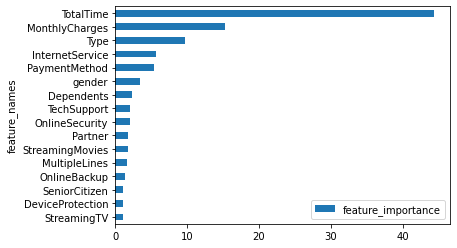

In [197]:
data.sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

По графику важности факторов, видим что бОльшая часть факторов незначительно влияют на целевую переменную, а значит их смело можно убирать из модели.  
Самые значимые факторы при этом: TotalTime и MonthlyCharges.

Лучшие результаты дала модель CatBoost:  
AUC-ROC: 0.89 и Accuracy: 0.85

Проверим ее на тестовых данных

## Тестирование лучшей модели

### Тестирование

In [191]:
cb_preds_test = model_cb.predict_proba(features_test)
prediction_cb_one_test = cb_preds_test[:, 1]

auc_roc_cb_test = roc_auc_score(target_test, prediction_cb_one_test).round(5)

cb_preds_test_acc = model_cb.predict(features_test)
accuracy_cb_test = accuracy_score(target_test, cb_preds_test_acc).round(5)

print('AUC-ROC:', auc_roc_cb_test,
      '\nAccuracy:', accuracy_cb_test)

AUC-ROC: 0.90053 
Accuracy: 0.83795


### Сравнение полученной метрики с ошибкой на базисной модели

В качестве базисной модели возьмем DummyClassifier

In [192]:
dummy_model = DummyClassifier(random_state=42)
dummy_model.fit(features_train, target_train)
dummy_predict = dummy_model.predict(features_test)

auc_roc_dummy = roc_auc_score(target_test, dummy_predict).round(5)
accuracy_dummy = accuracy_score(target_test, dummy_predict).round(5)

print('AUC-ROC:', auc_roc_dummy,
      '\nAccuracy:', accuracy_dummy)

AUC-ROC: 0.52256 
Accuracy: 0.62615


### Вывод
Полученные на лучшей модели значения метрик (Cat Boost: AUC-ROC=0.90 и Accuracy=0.84) значительно превышают значения метрик на базисной модели (Dummy: AUC-ROC=0.52 и Accuracy=0.63).  
Таким образом можно сделать вывод о том, что наша модель адекватна и подходит для предсказания оттока клиентов из телеком компании «Ниединогоразрыва.ком»